In [1]:
import numpy as np
from scene import Scene
from matplotlib import pyplot as plt
%matplotlib inline

## Load data

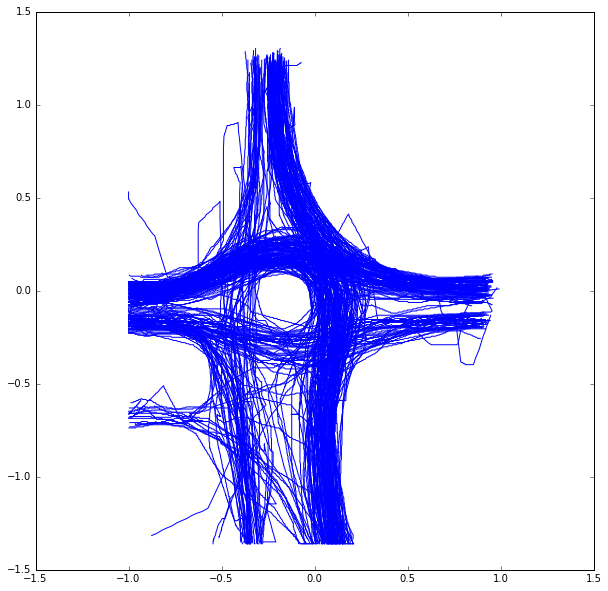

In [2]:
from process_data import get_BB_ts_list, BB_ts_to_curve, BB_to_position_and_velocity
BB_ts_list, V_scale = get_BB_ts_list('../annotations/deathCircle/video3/', label='Biker')
curve_list = map( BB_ts_to_curve, BB_ts_list )

fig = plt.figure( figsize = (10,10))
for BB_ts in BB_ts_list:
    plt.plot(BB_ts[0] , BB_ts[1], 'b-')
plt.axis('equal')
plt.show()

## Generate train-test split

In [3]:
from sklearn.cross_validation import KFold, train_test_split
n = len(BB_ts_list)
n_folds = 5
#kf = KFold(n, n_folds=n_folds, random_state = 42)
#for train, test in kf:
#    print "train = " + str(train)
#    print "test  = " + str(test)

In [4]:
train, test = train_test_split( BB_ts_list, random_state = 42)

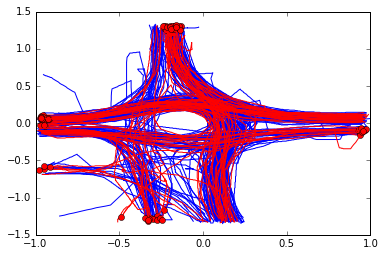

In [5]:
for BB_ts in train:
    x,y = BB_ts_to_curve(BB_ts)
    plt.plot( x, y, 'b-')
    
for BB_ts in test:
    x,y = BB_ts_to_curve( BB_ts )
    plt.plot(x, y, 'r-')
    plt.plot(x[0], y[0], 'ro')

## Train and see a prediction

Top speed = 0.190671
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
[ 0.18181818  0.17316017  0.17748918  0.04761905  0.04761905  0.08658009
  0.08225108  0.03463203  0.06926407  0.0995671 ]


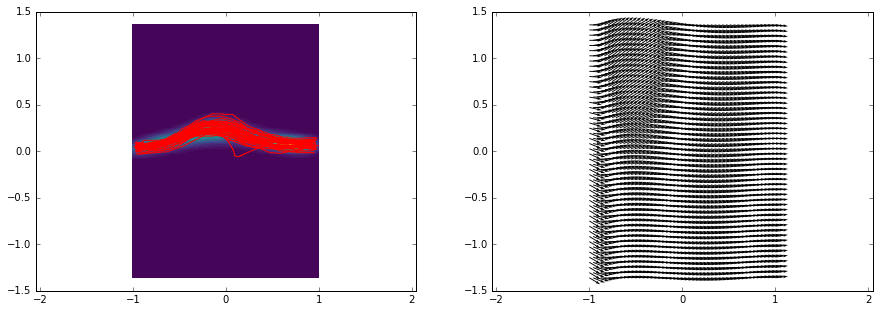

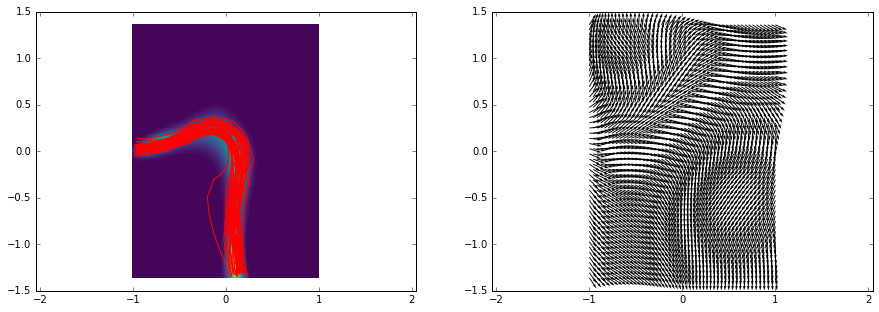

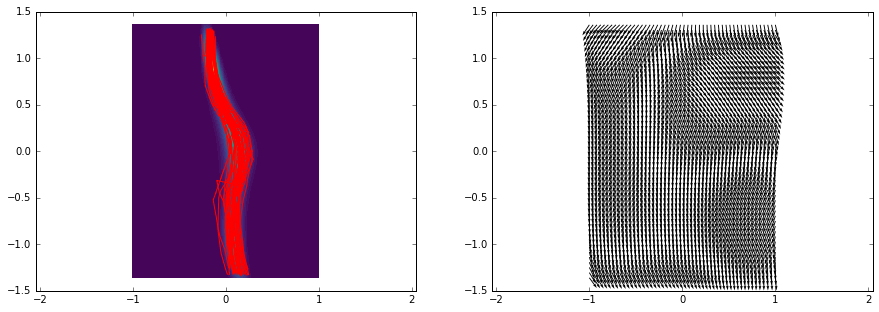

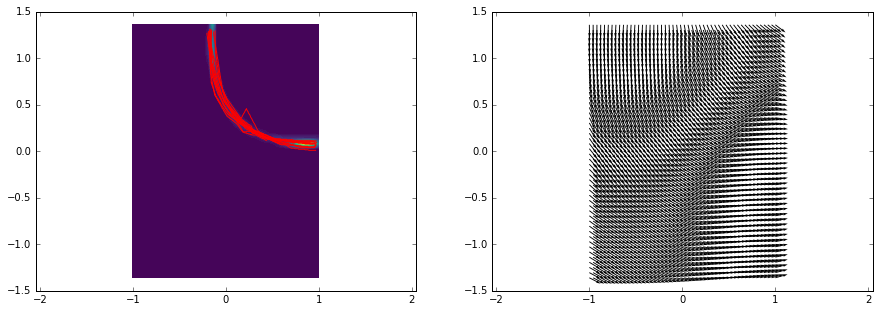

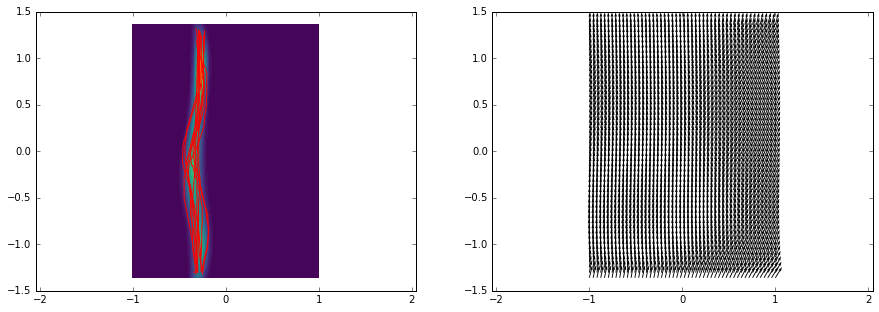

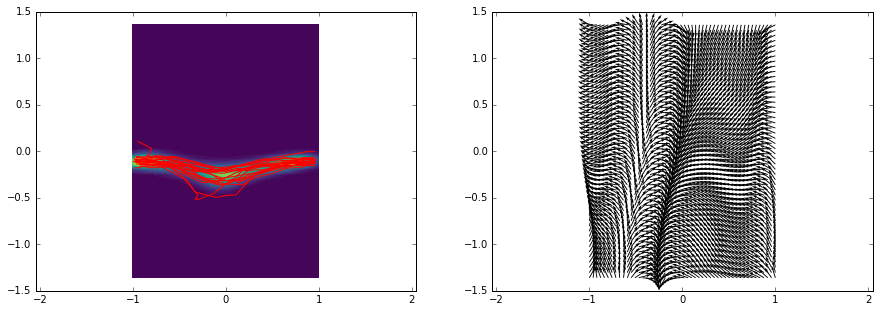

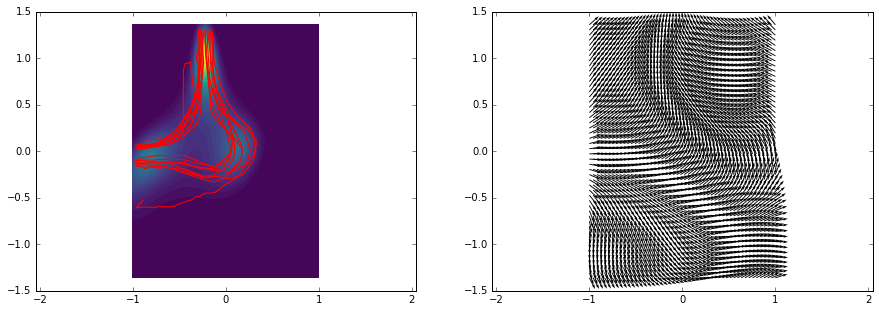

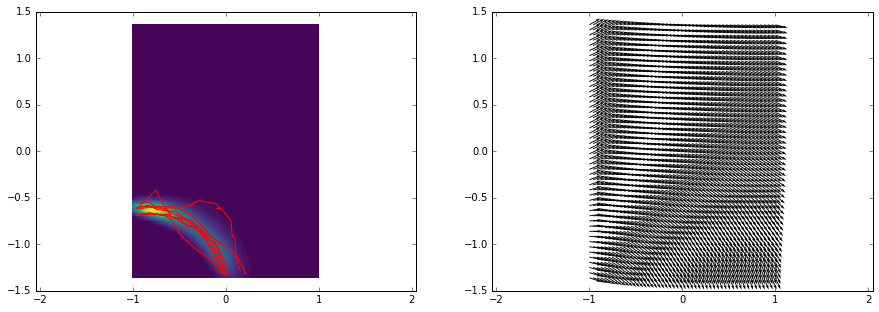

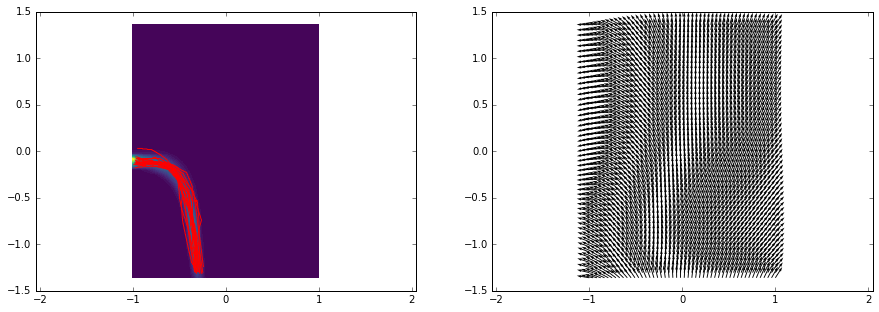

In [6]:
curve_list = map( BB_ts_to_curve, train )
scene = Scene( curve_list, V_scale, k_max_theta=15, k_max_vf=15 )

for k in range(scene.num_nl_classes):
    from visualization_routines import visualize_cluster
    visualize_cluster( scene, k)

P_c = 0.035950
c_0 case computed.

P_c = 0.000043
Skipping computation for class c_1.  P(c_1 | mu )=4.30132e-05 < 0.001 

P_c = 0.567021
c_2 case computed.

P_c = 0.000557
Skipping computation for class c_3.  P(c_3 | mu )=0.000557296 < 0.001 

P_c = 0.065203
c_4 case computed.

P_c = 0.000560
Skipping computation for class c_5.  P(c_5 | mu )=0.000560077 < 0.001 

P_c = 0.314161
c_6 case computed.

P_c = 0.014709
c_7 case computed.

P_c = 0.000013
Skipping computation for class c_8.  P(c_8 | mu )=1.26351e-05 < 0.001 

P_linear = 0.001782
integral of Us = 0.570392
integral of Linear = 0.363307


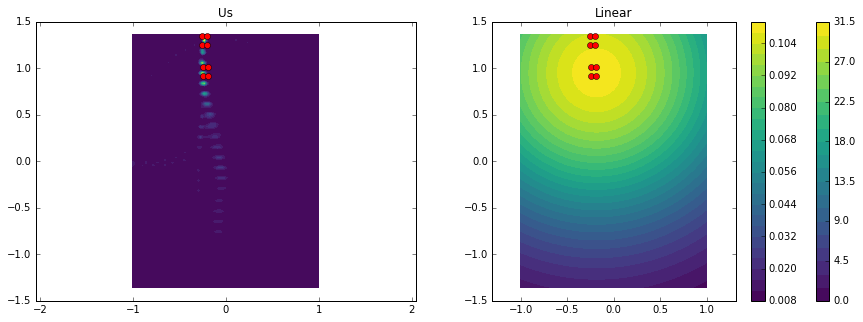

In [8]:
t0 = 2
subj = 0
BB_0 = test[subj][:,t0-2]
BB_1 = test[subj][:,t0+2]
mu, eta = BB_to_position_and_velocity(  BB_0, BB_1, delta_t = 4 )
scene.set_mu( mu )
scene.set_eta( eta )

x_span = np.linspace( -V_scale[0], V_scale[0], 100 )
y_span = np.linspace( -V_scale[1], V_scale[1], 100 )
dx, dy = x_span[1] - x_span[0], y_span[1] - y_span[0]
X_grid, Y_grid = np.meshgrid( x_span, y_span)

T=60
rho = scene.predict_pdf( X_grid, Y_grid, T)
fig, ax_arr = plt.subplots( 1,2, figsize = (15,5))
cs = ax_arr[0].contourf( X_grid, Y_grid, rho, 30, cmap = 'viridis')
#plot bounding boxes
for BB in [ 0.5*(BB_0+BB_1), test[subj][:,T]]:
    ax_arr[0].plot( [BB[0], BB[0], BB[2], BB[2] ], [BB[1],BB[3],BB[1],BB[3]], 'ro')
axis_lengths = ax_arr[0].axis('equal')
ax_arr[0].set_title('Us')
plt.colorbar(cs)

print "integral of Us = %f" % (rho.sum()*dx*dy)

rho_linear = scene.predict_pdf_linear( X_grid, Y_grid, T)
cs = ax_arr[1].contourf( X_grid, Y_grid, rho_linear, 30, cmap = 'viridis')
plt.colorbar(cs)
#plot bounding boxes
for BB in [ 0.5*(BB_0+BB_1), test[subj][:,T]]:
    ax_arr[1].plot( [BB[0], BB[0], BB[2], BB[2] ], [BB[1],BB[3],BB[1],BB[3]], 'ro')
axis_lengths = ax_arr[1].axis('equal')
ax_arr[1].set_title('Linear')

print "integral of Linear = %f" % (rho_linear.sum()*dx*dy)


## Measure Precision at a single T
To measure precision we consider a bounding box, $BB(T)$, at time $T > 0$ and test if
$$
    \int_{BB(T)} \rho_{\text{pred}} (T,x) dx > p_{\min}
$$
where $p_{\min}$ is something like $1\%$.  Perfect precision occurs when this test passes in all cases.

In [12]:
accuracy = 0
accuracy_linear = 0
p_min = 1e-3
for subj in range( len(test)):
    # Generate a grid over the bounding box at time T, compute prediction on the bounding box.
    BB_T = test[subj][:,T]
    x_span = np.linspace( BB_T[0], BB_T[2], 10)
    y_span = np.linspace( BB_T[1], BB_T[3], 10)
    X_grid, Y_grid = np.meshgrid( x_span, y_span)
    dx, dy = x_span[1] - x_span[0], y_span[1] - y_span[0]

    # initialize the scene
    t0 = 2
    BB_0 = test[subj][:,t0-2]
    BB_1 = test[subj][:,t0+2]
    mu, eta = BB_to_position_and_velocity(  BB_0, BB_1, delta_t = 4 )
    scene.set_mu( mu )
    scene.set_eta( eta )
    
    # Compute pdf on mesh
    rho = scene.predict_pdf( X_grid, Y_grid, T)
    rho_linear = scene.predict_pdf_linear( X_grid, Y_grid, T)
    # Compute integral
    Us = rho.sum()*dx*dy
    Linear = rho_linear.sum()*dx*dy
    print "Us     = %f" % Us
    print "Linear = %f" % Linear
    accuracy += 1 if Us > p_min else 0
    accuracy_linear += 1 if Linear > p_min else 0
    
print "our accuracy    = %d out of %d" % (accuracy, len(test))
print "linear accuracy = %d out of %d" % (accuracy_linear, len(test))

P_c = 0.000003
Skipping computation for class c_0.  P(c_0 | mu )=3.33287e-06 < 0.001 

P_c = 0.000000
Skipping computation for class c_1.  P(c_1 | mu )=4.21778e-08 < 0.001 

P_c = 0.520397
c_2 case computed.

P_c = 0.007084
c_3 case computed.

P_c = 0.108175
c_4 case computed.

P_c = 0.000000
Skipping computation for class c_5.  P(c_5 | mu )=1.54606e-13 < 0.001 

P_c = 0.365681
c_6 case computed.

P_c = 0.000001
Skipping computation for class c_7.  P(c_7 | mu )=1.05727e-06 < 0.001 

P_c = 0.000000
Skipping computation for class c_8.  P(c_8 | mu )=1.32652e-07 < 0.001 

P_linear = -0.001343
Us     = 0.001954
Linear = 0.000027
P_c = 0.915793
c_0 case computed.

P_c = 0.318992
c_1 case computed.

P_c = 0.000002
Skipping computation for class c_2.  P(c_2 | mu )=1.7915e-06 < 0.001 

P_c = 0.000000
Skipping computation for class c_3.  P(c_3 | mu )=5.36963e-12 < 0.001 

P_c = 0.000000
Skipping computation for class c_4.  P(c_4 | mu )=1.77844e-09 < 0.001 

P_c = 0.007841
c_5 case computed.

P_c

ValueError: x, y are incompatible